# Qubit calibration code

Dec 2022
Jeff and Joao

In [2]:
from qick import *
from qick.averager_program import *
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import csv
from datetime import date
from scipy.optimize import curve_fit
from scipy.optimize import leastsq,minimize
from scipy import stats
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
soc = QickSoc()
soccfg = soc
print(soccfg)


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v4 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v4 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v4 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v4 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v4 - tProc output 6, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_signal_gen_v4 - tProc out

### Qubit+Readout  DAC channel = 2_230
### ADC channel = 0_226

In [39]:
hw_cfg={"jpa_ch":6,
        "res_ch":0,
        "qubit_ch":2,
        "storage_ch":0
       }
readout_cfg={
    "readout_length":1000, # [Clock ticks]
    "res_length":soccfg.us2cycles(1.75, gen_ch=2),
    "f_res":6794.2, # [MHz]
    "res_phase": 0,
    "adc_trig_offset": 50, # [Clock ticks]
    "res_gain":1500,
    "drive_ro_delay":soccfg.us2cycles(0.05, gen_ch=2),
    "res_sigma":soccfg.us2cycles(2.12, gen_ch=2),
    }
qubit_cfg={
    "pulse_length":soccfg.us2cycles(0.0356, gen_ch=2),
    "pi_gain": 10000,
    "f_ge":5552.5,#5448.826,
    "relax_delay":80,
    "delta":-224.852,
    "sigma":soccfg.us2cycles(0.128, gen_ch=2),
    "alpha":0,
    "threshold":1.597776306284787,
    "angle":[-1.3555578265530446,0]
}

# 

## Plotting functions

In [5]:
def plotsave2d(plot, save, title, trial, xvar, xvarname, yvar, yvarname, zdata, zdataname, **kwargs):
        
        #arguments:
        #
        #freq (MHz)
        #gain (a.u.)
        #phase (deg)
        #shape
        #etc.
        
        if plot is not None and plot:
            pcm=plt.pcolormesh(xvar, yvar, zdata)
            plt.xlabel(xvarname)
            plt.ylabel(yvarname)
            plt.colorbar(pcm, label=zdataname)
            plt.title(title)
            
        if save is not None and save:
                today=date.today()
                if trial is None:
                    trial="01"
                if plot is not None and plot:
                    plt.savefig('images/Stark-{}-{}-{}.pdf'.format(title, today, trial))
                
                with open('measurement_data/Stark-{}-{}-{}.csv'.format(title, today, trial), 'w', encoding='UTF-8') as f:
    
                    writer = csv.writer(f)
                    writer.writerows([[title],[]])
                    for key, value in kwargs.items():
                        writer.writerow(["%s: %s" % (key, value)])
                    writer.writerow([])
                    
                df=pd.DataFrame(zdata, index=yvar, columns=xvar)
                df.to_csv('measurement_data/Stark-{}-{}-{}.csv'.format(title, today, trial), mode='a', header=True)

In [6]:
def plotsave1d(plot, save, title, trial, xvar, xvarname, ydata, ydataname, fitfunc=None, **kwargs):
        
        #arguments:
        #
        #freq (MHz)
        #gain (a.u.)
        #phase (deg)
        #shape
        #etc.
        
        if plot is not None and plot:
            plt.plot(xvar, ydata, 'o-')
            if fitfunc is not None:
                plt.plot(xvar, fitfunc, 'k--')
            plt.xlabel(xvarname)
            plt.ylabel(ydataname)
            plt.title(title)
            
        if save is not None and save:
                today=date.today()
                if trial is None:
                    trial="01"
                if plot is not None and plot:
                    plt.savefig('images/Stark-{}-{}-{}.pdf'.format(title, today, trial))
                
                with open('measurement_data/Stark-{}-{}-{}.csv'.format(title, today, trial), 'w') as f:
    
                    writer = csv.writer(f)
                    writer.writerows([[title],[]])
                    for key, value in kwargs.items():
                        writer.writerow(["%s: %s" % (key, value)])
                    writer.writerow([])
                    
                df=pd.DataFrame(ydata, index=xvar)
                df.to_csv('measurement_data/Stark-{}-{}-{}.csv'.format(title, today, trial), mode='a', header=False)

## Fit functions

In [7]:
def sinfunc(x,A,W,P,L):
    return np.sin(W*x+P)*A+L

def exp_decay(x, A, B, T):
    return A*np.exp(-x/T)+B

def t2fit(x, A, W, T, B):
    return np.exp(-x/T)*np.cos(W*x)*A+B

# 

# 

# 

# 

# 

# 

# 

# 

# 

## Send continuous signal

In [64]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["qubit_ch"]

        self.declare_gen(ch=cfg["qubit_ch"], nqz=2)
        
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=0, gain=gain)

        self.set_pulse_registers(ch=res_ch, style="const", length=cfg["length"], mode="periodic")
        
        self.synci(200)
    
    def body(self):
        
        self.pulse(ch=self.cfg["qubit_ch"])
        self.wait_all()

In [65]:
def ContinuousSignal(freq, gain):
    config={"qubit_ch":2,
            "reps":1,
            "relax_delay":1.0,
            "length":1000,
            "pulse_gain":gain,
            "pulse_freq":freq,
            "soft_avgs":1
           }

    prog =LoopbackProgram(soccfg, config)

    avgq, avgi = prog.acquire(soc, load_pulses=True, progress=True, debug=False)

In [66]:
ContinuousSignal(4000,10000)

  0%|          | 0/1 [00:00<?, ?it/s]

In [547]:
soc.reset_gens()

# 

# 

# 

# 

# 

# 

# 

# 

## Finding the frequency of the readout resonator

In [68]:
class SingleToneSpectroscopyProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg 
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2)
        
        
        self.r_rp=self.ch_page(self.cfg["qubit_ch"])
        self.r_gain=self.sreg(cfg["qubit_ch"], "gain")
        
        for ch in [0]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["frequency"], gen_ch=cfg["qubit_ch"])
            
        freq = self.freq2reg(cfg["frequency"], gen_ch=cfg["qubit_ch"], ro_ch=0)
        
        self.add_gauss(ch=cfg["qubit_ch"], name="measure", sigma=cfg["res_sigma"], length=cfg["res_length"])
            
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="flat_top", waveform="measure", freq=freq, length=cfg["res_length"], 
                                 phase=0, gain=cfg["start"])
        
        self.synci(200)
    
    def body(self):
        cfg=self.cfg
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=cfg["adc_trig_offset"])
        
        self.pulse(ch=cfg["qubit_ch"])
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))
        
    def update(self):
        self.mathi(self.r_rp, self.r_gain, self.r_gain, '+', self.cfg["step"])

In [69]:
def ROFrequency(ro_length, f_start, f_stop, f_expts, g_start, g_stop, g_expts, plot=None, save=None, trial=None):
    
    expt_cfg={"reps":50, "relax_delay":10, "f_start":f_start, "f_stop":f_stop, "f_expts":f_expts, 
              "start":g_start, "step":int((g_stop-g_start)/g_expts), "expts":g_expts}

    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg}
    
    config["res_length"]=soccfg.us2cycles(ro_length,gen_ch=2)
    f_range=np.linspace(config["f_start"], config["f_stop"], config["f_expts"])

    amps=[]
    for i in tqdm(f_range):
        config["frequency"]=i,
        rspec=SingleToneSpectroscopyProgram(soccfg, config)
        expt_pts, avgi,avgq=rspec.acquire(soc, load_pulses=True, progress=False)
        amp=np.abs(avgi[0][0]+1j*avgq[0][0])
        amps.append(amp)
    
    amps=np.array(amps)
    background=np.mean(amps[0:int(f_expts/6)])
    
    plotsave2d(plot=plot, save=save, title="RR Spectroscopy", trial=trial, xvar=f_range,
              xvarname="Frequency (MHz)", yvar=expt_pts, yvarname="DAC Gain (a.u.)", zdata=(amps/background).T,
              zdataname="Transmission amplitude", Length=ro_length, Shape="Flat top pulse")
    
    #return amps.T

  0%|          | 0/100 [00:00<?, ?it/s]

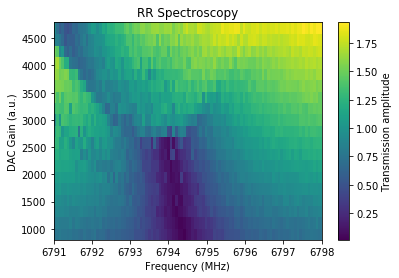

In [76]:
ROFrequency(2.0, 6791,6798,100,800,5000,20, plot=True, save=False, trial="gaussian")

# 

# 

# Finding the qubit drive frequency

In [343]:
class PulseProbeSpectroscopyProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2)
        
        for ch in [0]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["qubit_ch"])
            
             
        global freq
        freq = self.freq2reg(cfg["f_res"], gen_ch=cfg["qubit_ch"], ro_ch=0)
        
        self.default_pulse_registers(ch=cfg["qubit_ch"], phase=0)
        self.add_DRAG(ch=cfg["qubit_ch"], name="drive", length=cfg["probe_length"], sigma=cfg["probe_length"],
                      delta=cfg["delta"], alpha=cfg["alpha"])
        self.add_gauss(ch=cfg["qubit_ch"], name="measure", sigma=cfg["res_sigma"], length=cfg["res_length"])
            
        
        self.sync_all(200)
    
    def body(self):
        cfg=self.cfg
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=self.freq2reg(cfg["qubit_freq"], gen_ch=cfg["qubit_ch"]), 
                                 gain=cfg["qubit_gain"], waveform="drive")
        self.pulse(ch=self.cfg["qubit_ch"], t=0)
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="flat_top", waveform="measure", freq=freq, length=cfg["res_length"], 
                                 gain=cfg["res_gain"])
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=cfg["adc_trig_offset"], t=int(cfg["probe_length"]+cfg["drive_ro_delay"]))
        
        self.pulse(ch=cfg["qubit_ch"], t=int(cfg["probe_length"]+cfg["drive_ro_delay"]))
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

In [396]:
def QubitSpectroscopy(probe_length, gain, reps, f_start, f_stop, f_expts, plot=None, save=None, trial=None):
    expt_cfg={"reps": reps,"rounds":1,
              "probe_length":soccfg.us2cycles(probe_length, gen_ch=2), "qubit_gain":gain
             }

    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg}
    if config["threshold"] is not None:
        corr=config["readout_length"]
    else:
        corr=1
    amps=[]
    for i in tqdm(np.linspace(f_start,f_stop,f_expts)):
        config["qubit_freq"]=i
        qspec=PulseProbeSpectroscopyProgram(soccfg, config)
        avgi, avgq = qspec.acquire(soc, threshold=config["threshold"], angle=config["angle"], load_pulses=True, progress=False, debug=False)
        
        amps.append(np.sqrt(avgi[0][0]**2+avgq[0][0]**2)*corr)

    subplot(111,title="Qubit Spectroscopy", xlabel="Qubit Frequency (MHz)", ylabel="Qubit Population")

    plotsave1d(plot=plot, save=save, title="Qubit Spectroscopy", trial=trial, xvar=np.linspace(f_start,f_stop,f_expts),
              xvarname="Qubit Frequency", ydata=amps, ydataname="IQ amplitude", Length=probe_length, Gain=gain, Shape="arb")
    
    #return amps

  0%|          | 0/100 [00:00<?, ?it/s]

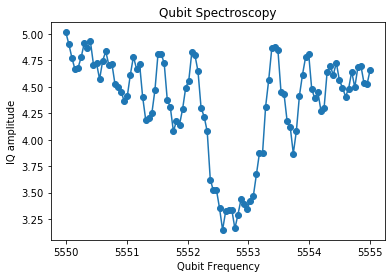

In [397]:
QubitSpectroscopy(3.0, 800, 300, 5550, 5555, 100, plot=True, save=True, trial="actual-transition-frequency")

  0%|          | 0/250 [00:00<?, ?it/s]

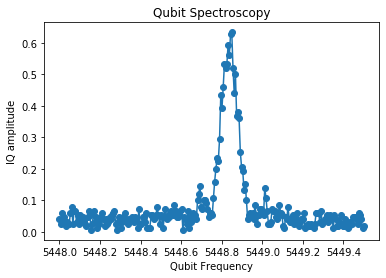

In [346]:
QubitSpectroscopy(5.0, 6000, 150, 5448, 5449.5, 250, plot=True, save=False, trial="higher-transition-focused-F")

In [126]:
soc.reset_gens()

# 

# 

# 

# 

# 

# 

# 

## Length Rabi

In [8]:
class LengthRabiProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg

        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["qubit_ch"])
        

        self.default_pulse_registers(ch=cfg["qubit_ch"], phase=0)
        self.add_DRAG(ch=cfg["qubit_ch"], name="drive", length=cfg["qubit_length"], sigma=cfg["qubit_length"],
                      delta=cfg["delta"], alpha=cfg["alpha"])
        self.add_gauss(ch=cfg["qubit_ch"], name="measure", sigma=cfg["res_sigma"], length=cfg["res_length"])
            
        self.synci(200)
        
    def body(self):
        cfg=self.cfg

        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["qubit_ch"], ro_ch=0)
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])
        
        #self.set_pulse_registers(ch=cfg["qubit_ch"], style="const", freq=f_ge, gain=cfg["qubit_gain"], length=cfg["qubit_length"])
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", waveform="drive", freq=f_ge, gain=cfg["qubit_gain"])
        self.pulse(ch=cfg["qubit_ch"], t=0)
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="flat_top", waveform="measure", freq=f_res, length=cfg["res_length"], 
                                 gain=cfg["res_gain"])
        
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=cfg["adc_trig_offset"], t=int(cfg["qubit_length"]+cfg["drive_ro_delay"]))
        
        self.pulse(ch=cfg["qubit_ch"], t=int(cfg["qubit_length"]+cfg["drive_ro_delay"]))
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

In [9]:
def LengthRabi(gain, start, stop, expts, reps, plot=None, save=None, trial=None):
    expt_cfg={
            "qubit_gain":gain,
            "start":start, "stop":stop, "expts":expts, "reps":reps,
           }
    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg}
    if config["threshold"] is not None:
        corr=config["readout_length"]
    else:
        corr=1
    results=[]
    for l in tqdm(np.linspace(soccfg.us2cycles(start), soccfg.us2cycles(stop), expts)+4):
        config["qubit_length"]=l

        rabi=LengthRabiProgram(soccfg, config)
        avgi,avgq = rabi.acquire(soc, threshold=config["threshold"], angle=config["angle"], load_pulses=True, progress=False,debug=False)
        results.append(np.sqrt(avgi[0][0]**2+avgq[0][0]**2)*corr)
    
    minvalue=np.min(results)
    maxvalue=np.max(results)
    amplitude=maxvalue-minvalue
    maxsin=np.where(results>maxvalue-0.2*amplitude)[0][0]
    try:
        minsin=np.where(results<minvalue+0.2*amplitude)[0][np.where(results<minvalue+0.2*amplitude)[0]>maxsin][0]
    except:
        minsin=np.where(results<minvalue+0.2*amplitude)[0][0]

    p_guess = [amplitude/2,np.pi/(minsin-maxsin),np.pi/2,np.mean(results)]
    p_opt, p_cov = curve_fit(sinfunc, np.arange(expts), results, p0 = p_guess)
    p_err = np.sqrt(np.diag(p_cov))

    fitfunc=sinfunc(np.arange(expts),p_opt[0],p_opt[1],p_opt[2],p_opt[3])
    fitvalues=p_opt
    fitvalueserr=p_err
    
    plotsave1d(plot=plot, save=save, title="Length Rabi", trial=trial, xvar=np.linspace(start,stop,expts)*1000+9.3,
              xvarname="Pulse length (ns)", ydata=results,ydataname="IQ amplitude", fitfunc=fitfunc, Gain=gain, Shape="square pulse",
              Fitvalues=fitvalues, Fitvalueserr=fitvalueserr)

    step=np.linspace(start, stop, expts)[1]-np.linspace(start, stop, expts)[0]
    pipulse = np.pi/p_opt[1]*step
    return {'pipulse':pipulse}#, 'results':results}

  0%|          | 0/200 [00:00<?, ?it/s]

-0.07033876766670495

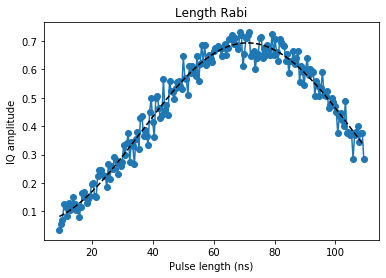

In [10]:
qubit_cfg["alpha"]=0
LengthRabi(5000,0,0.1,200,200, plot=True, save=False, trial="with_0_drag")['pipulse']

# 

# 

# 

# Amplitude Rabi (not working, need Spectrum Analyzer)

In [14]:
class AmplitudeRabiProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg

        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["qubit_ch"])
        
        self.r_rp=self.ch_page(cfg["qubit_ch"])
        self.r_gain=self.sreg(cfg["qubit_ch"], "gain")
        
        self.default_pulse_registers(ch=cfg["qubit_ch"], phase=0)
        self.add_DRAG(ch=cfg["qubit_ch"], name="drive", length=cfg["qubit_length"], sigma=cfg["qubit_length"],
                      delta=cfg["delta"], alpha=cfg["alpha"])
        self.add_gauss(ch=cfg["qubit_ch"], name="measure", sigma=cfg["res_sigma"], length=cfg["res_length"])

        self.synci(200)
        
    def body(self):
        cfg=self.cfg

        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["qubit_ch"], ro_ch=0)
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", waveform="drive", freq=f_ge, gain=cfg["start"])
        self.pulse(ch=cfg["qubit_ch"], t=0)
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="flat_top", waveform="measure", freq=f_res, length=cfg["res_length"], 
                                 gain=cfg["res_gain"])
        
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=cfg["adc_trig_offset"], t=int(cfg["qubit_length"]+cfg["drive_ro_delay"]))
        
        self.pulse(ch=cfg["qubit_ch"], t=int(cfg["qubit_length"]+cfg["drive_ro_delay"]))
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))
    
    def update(self):
        self.mathi(self.r_rp, self.r_gain, self.r_gain, '+', self.cfg["step"])

In [19]:
def AmplitudeRabi(length, start, step, expts, reps, plot=None, save=None, trial=None):
    expt_cfg={
            "qubit_length":soccfg.us2cycles(length),
            "start":start, "step":step, "expts":expts, "reps":reps,
           }
    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg}
    if config["threshold"] is not None:
        corr=config["readout_length"]
    else:
        corr=1
    rabi = AmplitudeRabiProgram(soccfg, config)
    expt_pts, avgi,avgq = rabi.acquire(soc, threshold=None, angle=None, load_pulses=True, progress=False,debug=False)
    results = np.sqrt(avgi[0][0]**2+avgq[0][0]**2)#*corr
    
    minvalue=np.min(results)
    maxvalue=np.max(results)
    amplitude=maxvalue-minvalue
    maxsin=np.where(results>maxvalue-0.2*amplitude)[0][0]
    try:
        minsin=np.where(results<minvalue+0.2*amplitude)[0][np.where(results<minvalue+0.2*amplitude)[0]>maxsin][0]
    except:
        minsin=np.where(results<minvalue+0.2*amplitude)[0][0]

    p_guess = [amplitude/2,np.pi/(minsin-maxsin),-np.pi/2,np.mean(results)]
    p_opt, p_cov = curve_fit(sinfunc, np.arange(expts), results, p0 = p_guess)
    p_err = np.sqrt(np.diag(p_cov))

    fitfunc=sinfunc(np.arange(expts),p_opt[0],p_opt[1],p_opt[2],p_opt[3])
    fitvalues=p_opt
    fitvalueserr=p_err
    
    plotsave1d(plot=plot, save=save, title="Amplitude Rabi", trial=trial, xvar=np.arange(expts)*step+start,
               xvarname="Gain", ydata=results,ydataname="IQ amplitude", fitfunc=fitfunc, Length=length, Shape="square pulse",
              Fitvalues=fitvalues, Fitvalueserr=fitvalueserr)

    pipulse = np.pi/p_opt[1]*step
    return {'pipulse':pipulse}#, 'results':results}

{'pipulse': 943.6097191799585}

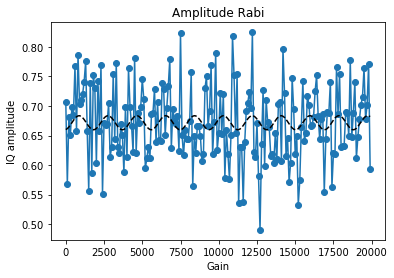

In [20]:
AmplitudeRabi(0.05, 0, 100, 200, 150, plot=True)

# 

# 

# 

# 

# 

# 

# 

# Use SA to find out why no sweep across gain happens (maybe change to NDap)

In [22]:
class IQProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg

        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["qubit_ch"])
        
        self.r_rp=self.ch_page(cfg["qubit_ch"])
        self.r_gain=self.sreg(cfg["qubit_ch"], "gain")
        
        self.default_pulse_registers(ch=cfg["qubit_ch"])
        self.add_DRAG(ch=cfg["qubit_ch"], name="drive", length=cfg["qubit_length"], sigma=cfg["qubit_length"],
                      delta=cfg["delta"], alpha=cfg["alpha"])
        self.add_gauss(ch=cfg["qubit_ch"], name="measure", sigma=cfg["res_sigma"], length=cfg["res_length"])

        self.synci(200)
        
    def body(self):
        cfg=self.cfg

        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["qubit_ch"], ro_ch=0)
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style='arb', waveform="drive", phase=0, freq=f_ge, gain=cfg["start"])
        self.pulse(ch=cfg["qubit_ch"])
        self.sync_all(self.cfg["drive_ro_delay"])
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style='flat_top', waveform='measure', freq=f_res, 
                                 phase=self.deg2reg(0*180/np.pi), 
                                 gain=cfg["res_gain"], length=cfg["res_length"])
        
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=cfg["adc_trig_offset"])
        
        self.pulse(ch=cfg["qubit_ch"])
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))
        
    def acquire(self,soc, load_pulses=True, progress=False, debug=False):
        super().acquire(soc, load_pulses=load_pulses, progress=progress, debug=debug)
        return self.collect_shots()
        
    def collect_shots(self):
        shots_i0=self.di_buf[0]/self.cfg['readout_length']
        shots_q0=self.dq_buf[0]/self.cfg['readout_length']
        return shots_i0,shots_q0

In [23]:
def IQblobs(length, pi_gain, reps, ro_feats=None, drive_feats=None, angle=None, plot=None, save=None, trial=None):
    expt_cfg={
            "qubit_length":soccfg.us2cycles(length),
            "start":0, "step":pi_gain, "expts":2, "reps":reps,
           }
    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg}
    if ro_feats is not None:
        config["res_length"]=soccfg.us2cycles(ro_feats[0])
        config["res_sigma"]=soccfg.us2cycles(ro_feats[1])
        config["f_res"]=ro_feats[2]
        config["res_gain"]=int(ro_feats[3])
    #if drive_feats is not None:  
        #config["sigma"]=
        #config["delta"]=
        #config["qubit_length"]+
    
    iq = IQProgram(soccfg, config)
    avgi0, avgq0 = iq.acquire(soc, load_pulses=True, progress=False,debug=False)
    config["start"]=pi_gain
    iq = IQProgram(soccfg, config)
    avgi1, avgq1 = iq.acquire(soc, load_pulses=True, progress=False,debug=False)
    
    if plot is not None and plot:
        plt.scatter(avgi1,avgq1)
        plt.scatter(avgi0,avgq0)
        plt.axis("equal")
    
    return avgi0, avgq0, avgi1, avgq1

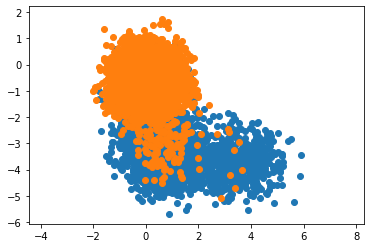

In [37]:
data=IQblobs(0.0356, 10000, 5000, plot=True)

(1.4814222932481023, 1.597776306284787, 1.3555578265530446)

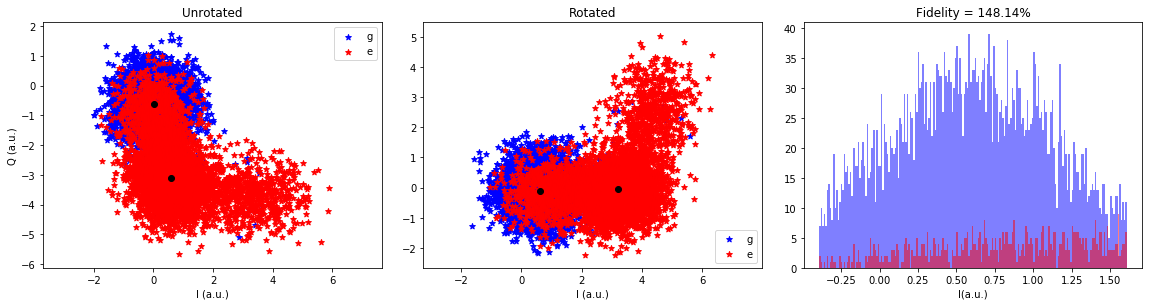

In [38]:
hist(data=data)

In [25]:
def maximize_visibility(I0s,Q0s,I1s,Q1s,initial_center,plot=True):
    """Find the center of the pi pulse IQ scatter data to maximize visibility."""
    I0 = np.mean(I0s)
    Q0 = np.mean(Q0s)
    def visibility(p,plot=False):
        I0s_shift = I0s - (p[0]+I0)/2.0
        Q0s_shift = Q0s - (p[1]+Q0)/2.0
        I1s_shift = I1s - (p[0]+I0)/2.0
        Q1s_shift = Q1s - (p[1]+Q0)/2.0
        angle = np.angle(-1j*p[1]-p[0]+1j*Q0+I0)
        rot_mat = np.array([[np.cos(angle),np.sin(angle)],[-np.sin(angle),np.cos(angle)]])
        IQ0s = np.dot(rot_mat,np.vstack([I0s_shift,Q0s_shift]))
        IQ1s = np.dot(rot_mat,np.vstack([I1s_shift,Q1s_shift]))
        I0_rot = IQ0s[0]
        I1_rot = IQ1s[0]
        prob0 = float(I0_rot[I0_rot<0].size)/I0_rot.size
        prob1 = float(I1_rot[I1_rot<0].size)/I1_rot.size
        if plot is True:
            y0,x0 = np.histogram(I0_rot,bins=50,normed=True)
            y1,x1 = np.histogram(I1_rot,bins=50,normed=True)
            x0 = (x0[:-1]+x0[1:])/2.0
            x1 = (x1[:-1]+x1[1:])/2.0
            probs0 = np.cumsum(y0)*(x0[1]-x0[0])
            probs1 = np.cumsum(y1)*(x1[1]-x1[0])
            x_visibility = np.linspace(min([x0[0],x1[0]]),max([x0[-1],x1[-1]]),1001)
            vis = []
            for x in x_visibility:
                prob0_fit = np.interp(x,x0,probs0,left=0,right=1)
                prob1_fit = np.interp(x,x1,probs1,left=0,right=1)
                vis.append(prob1_fit - prob0_fit)
            best_vis = np.max(vis)

            fig,ax1 = plt.subplots()
            plt.sca(ax1)
            plt.hist(I0_rot,color='b',bins=50,alpha=0.5,normed=True,label='|0>')
            plt.hist(I1_rot,color='r',bins=50,alpha=0.5,normed=True,label='|1>')
            plt.xlabel('Projection Position')
            plt.ylabel('Probability Density')
            plt.legend(loc=2)
            ax2 = ax1.twinx()
            plt.sca(ax2)
            plt.plot(x0,probs0,'b',label='|0>')
            plt.plot(x1,probs1,'r',label='|1>')
            plt.plot(x_visibility,vis,'g',label='|1>-|0>')
            plt.ylabel('Probability')
            plt.ylim([0,1])
            plt.legend(loc=6)
            plt.grid(True,which='both')
            plt.title('Best Visibility %.3f'%best_vis)
            plt.show()
        return prob1 - prob0

    def fit_func(p):
        return -visibility(p,plot=False)
    res = minimize(fit_func,initial_center,method='Nelder-Mead')
    if plot:
        visibility(res.x,plot=True)
    #print ('initial |1> state center:',initial_center)
    #print ('optimized |1> state center:',res.x)
    #print ('optimized visibility:',-res.fun)
    return -res.fun

In [26]:
def hist(data=None, plot=True, ran=1.0):
    
    ig = data[0]
    qg = data[1]
    ie = data[2]
    qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -np.arctan2((ye-yg),(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*np.cos(theta) - qg*np.sin(theta)
    qg_new = ig*np.sin(theta) + qg*np.cos(theta) 
    ie_new = ie*np.cos(theta) - qe*np.sin(theta)
    qe_new = ie*np.sin(theta) + qe*np.cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)
    
    #print(xg, xe)
    
    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='lower right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
        axs[2].set_xlabel('I(a.u.)')       
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    contrast = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum())))
    tind=contrast.argmax()
    threshold=binsg[tind]
    fid = contrast[tind]
    axs[2].set_title(f"Fidelity = {fid*100:.2f}%")

    return fid, threshold, theta

In [28]:
def calc_visibility(n_datapoints, ro_feats=None, drive_feats=None, plot=None):
    if plot is None:
        plot = False
    a, b, c, d = IQblobs(0.0356, 10000, n_datapoints, ro_feats, plot=False)
    initial_center=[np.mean(c),np.mean(d)]        
    return maximize_visibility(a,b,c,d, initial_center, plot=plot)

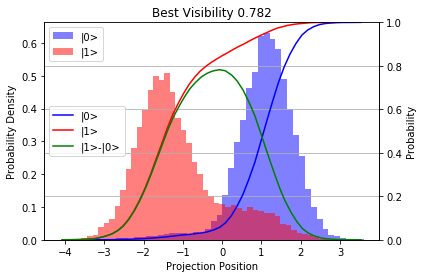

0.7837000000000001

In [29]:
calc_visibility(10000, [1.75, 2.12, 6794.2, 1500], plot=True)
#plt.savefig('images/StarkIQgaussianRO.pdf')

In [426]:
def differential_evolution(func, n_walkers, steps, thresh, evol, bounds, params, plot=None):
    
    bounds=np.array(bounds)
    n_features=bounds.shape[0]
    
    x = np.random.rand(n_walkers, n_features)
    x = (bounds[:,1]-bounds[:,0])*x+bounds[:,0]
    xfinal = np.copy(x).reshape(1,n_walkers,n_features)

    xvals=[func(params, ro_feats=x[i]) for i in range(n_walkers)]
    xvalsfinal=np.copy(xvals)
    #print(x)
    #print(xvals)
    indexes = np.arange(n_walkers)
    
    for i in tqdm(range(steps)):
        
        mask = np.random.rand(n_walkers, n_features)<thresh
        rs = np.random.randint(n_features, size=n_walkers)
        rs = np.tile(np.arange(n_features), n_walkers).reshape(n_walkers, n_features)==np.array(rs).reshape(n_walkers,1)
        mask = np.logical_or(mask, rs)

        for ii in tqdm(range(n_walkers)):
            np.random.shuffle(indexes)
            r1, r2, r3 = indexes[indexes != ii][0:3]
            
            y = x[r1]+evol*(x[r2]-x[r3])

            y = y*mask[ii]+x[ii]*(1-mask[ii])
            
            yval=func(params, ro_feats=y)
            
            if yval>xvals[ii]:
                x[ii]=y
                xvals[ii]=yval
        
        xfinal=np.concatenate((xfinal, np.array(x).reshape(1,n_walkers,n_features)))
        xvalsfinal=np.vstack((xvalsfinal, xvals))
    
    if plot is not None and plot:
        fig, axs = plt.subplots(5,1, figsize=(10,25))
        for i in range(steps+1):
            axs[0].scatter(np.ones(n_walkers)*i, xfinal[i,:,0], label=i)
            axs[0].set_xlabel('step')
            axs[0].set_ylabel('pulse length (us)')
            axs[1].scatter(np.ones(n_walkers)*i, xfinal[i,:,2], label=i)
            axs[1].set_xlabel('step')
            axs[1].set_ylabel('frequency (MHz)')
            axs[2].scatter(np.ones(n_walkers)*i, xfinal[i,:,3], label=i)
            axs[2].set_xlabel('step')
            axs[2].set_ylabel('gain (a.u.)')
            axs[3].scatter(np.ones(n_walkers)*i, xvalsfinal[i], label=i)
            axs[3].set_xlabel('step')
            axs[3].set_ylabel('visibilities')
            axs[4].scatter(np.ones(n_walkers)*i, xfinal[i,:,1], label=i)
            axs[4].set_xlabel('step')
            axs[4].set_ylabel('sigma length (us)')
            
        plt.savefig('images/Stark-RO-optimization-corrected.png'.format(n_walkers, steps, params, evol))
            
    return xfinal[-1], xvalsfinal[-1]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

(array([[2.63543201e+00, 3.27585229e+00, 6.79438253e+03, 1.57622029e+03],
        [1.80565883e+00, 2.68027088e+00, 6.79412115e+03, 1.49359420e+03],
        [1.44629984e+00, 2.62312482e+00, 6.79448488e+03, 1.57179203e+03],
        [1.98324120e+00, 2.99085491e+00, 6.79417950e+03, 1.49996824e+03],
        [2.59969250e+00, 3.75603875e+00, 6.79258367e+03, 1.91428044e+03],
        [2.93751226e+00, 4.73491359e+00, 6.79404538e+03, 1.45718904e+03],
        [1.54778938e+00, 2.34930164e+00, 6.79432284e+03, 1.54428356e+03],
        [1.89059584e+00, 2.16963365e+00, 6.79162443e+03, 2.58832982e+03],
        [1.40930199e+00, 1.84827344e+00, 6.79157448e+03, 2.57242390e+03],
        [2.72925759e+00, 3.32600358e+00, 6.79222059e+03, 2.17250204e+03],
        [2.01347790e+00, 2.50371313e+00, 6.79189528e+03, 2.31813991e+03],
        [1.13573718e+00, 2.05354827e+00, 6.79190408e+03, 2.30091271e+03],
        [1.75297005e+00, 3.12507001e+00, 6.79198224e+03, 2.30813512e+03],
        [2.57651083e+00, 4.13517121e+0

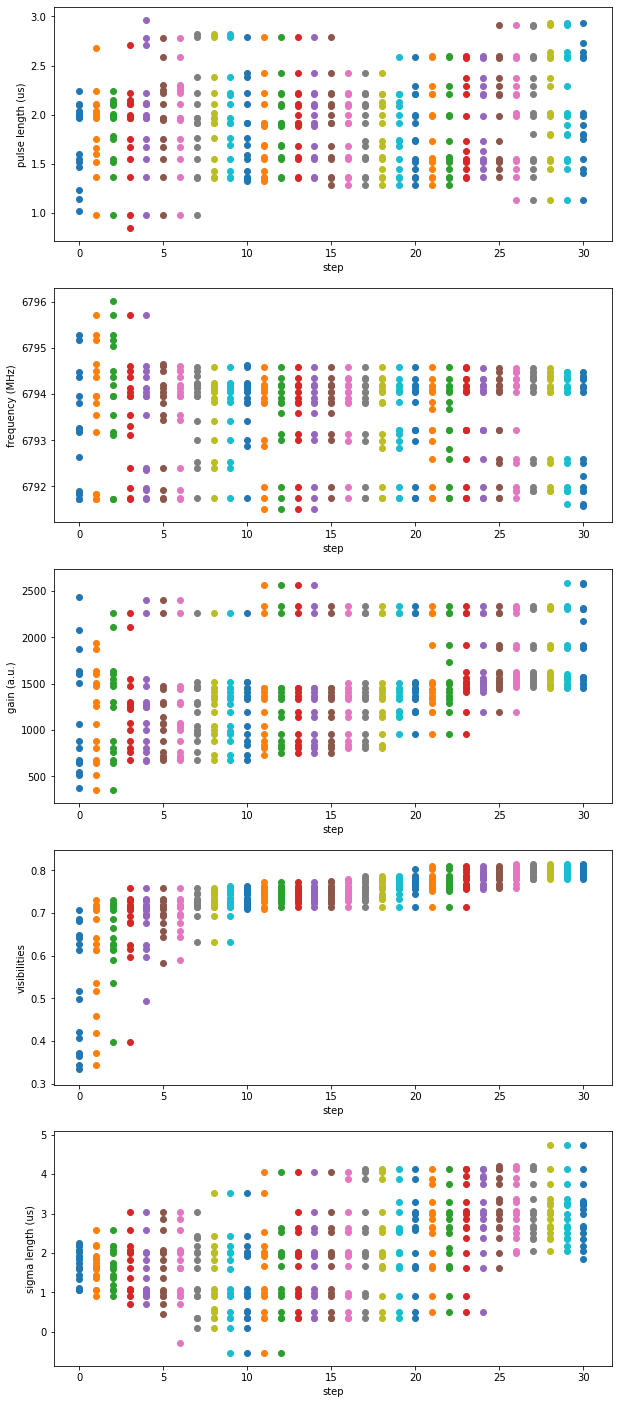

In [427]:
differential_evolution(calc_visibility, 15, 30, 0.8, 0.6, [[1, 2.5], [1, 2.5], [6791, 6796], [300,2500]], 5000, plot=True)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

(array([[1.38272921e+00, 1.74480001e+00, 6.79434731e+03, 1.56062076e+03],
        [1.89256936e+00, 2.46964066e+00, 6.79253221e+03, 1.85865058e+03],
        [1.83788453e+00, 2.68271402e+00, 6.79393281e+03, 1.38682061e+03],
        [1.66147235e+00, 2.19348531e+00, 6.79410037e+03, 1.44044898e+03],
        [1.22664760e+00, 1.40923471e+00, 6.79431506e+03, 1.53550484e+03],
        [1.42655605e+00, 1.41182899e+00, 6.79098872e+03, 3.05378829e+03],
        [1.54773670e+00, 2.08021996e+00, 6.79451733e+03, 1.64542997e+03],
        [1.69800697e+00, 1.80548452e+00, 6.79432773e+03, 1.56592072e+03],
        [1.82082989e+00, 2.64296836e+00, 6.79426863e+03, 1.54114988e+03],
        [1.90475643e+00, 3.16930606e+00, 6.79403168e+03, 1.43368982e+03],
        [1.68669207e+00, 1.76831625e+00, 6.79104247e+03, 3.09564816e+03],
        [2.06478369e+00, 2.41513154e+00, 6.79182362e+03, 2.30839088e+03],
        [1.76074030e+00, 2.38927200e+00, 6.79422431e+03, 1.49022042e+03],
        [1.62713129e+00, 1.93490518e+0

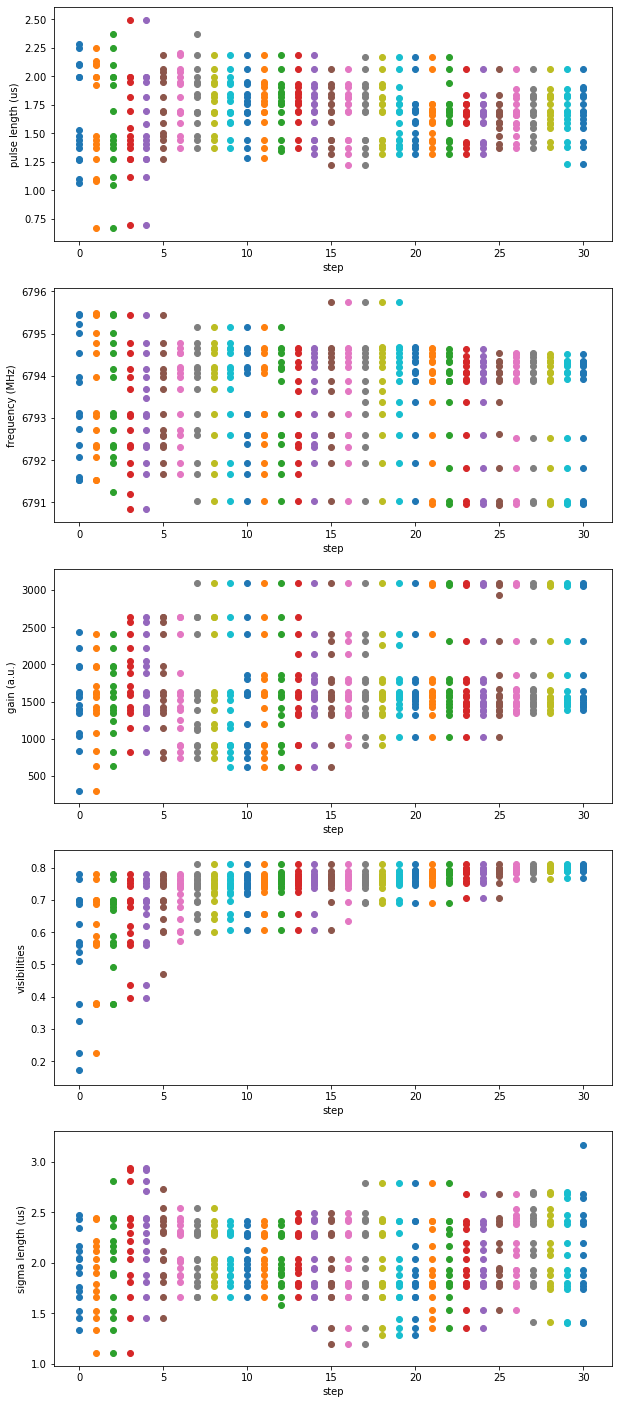

In [424]:
differential_evolution(calc_visibility, 15, 30, 0.8, 0.6, [[1, 2.5], [1, 2.5], [6791, 6796], [300,2500]], 5000, plot=True)

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

## T1 experiment

In [70]:
class T1Program(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_wait = 3
        self.regwi(self.q_rp, self.r_wait, cfg["start"])

        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        
        for ch in [0,1]: #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["qubit_ch"])
        
        
        self.add_DRAG(ch=cfg["qubit_ch"], name="drive", length=cfg["pulse_length"], sigma=cfg["pulse_length"],
                      delta=cfg["delta"], alpha=cfg["alpha"])
        self.add_gauss(ch=cfg["qubit_ch"], name="measure", sigma=cfg["res_sigma"], length=cfg["res_length"])

        self.sync_all(self.us2cycles(500))
    
    def body(self):
        cfg=self.cfg
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["qubit_ch"], ro_ch=0) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=0, gain=cfg["pi_gain"],
                                 waveform="drive")
        
        
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all()
        self.sync(self.q_rp,self.r_wait)
        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="flat_top", waveform="measure", freq=f_res, length=cfg["res_length"], 
                                 gain=cfg["res_gain"], phase=0)

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["qubit_ch"], 
             adcs=[0,1],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))
    
    def update(self):
        self.mathi(self.q_rp, self.r_wait, self.r_wait, '+', self.us2cycles(self.cfg["step"])) # update frequency list index

In [71]:
def T1(start, step, expts, reps, plot=None, save=None, trial=None):

    expt_cfg={ "start":start, "step":step, "expts":expts, "reps":reps,
            "relax_delay":250
           }
    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs
    if config["threshold"] is not None:
        corr=config["readout_length"]
    else:
        corr=1
    t1p=T1Program(soccfg, config)

    x_pts, avgi, avgq = t1p.acquire(soc, threshold=config["threshold"], angle=config["angle"], load_pulses=True, progress=True, debug=False)
    
    subplot(111, title="T1 Experiment", xlabel=f"Time ($\mu s$)", ylabel="Qubit Population")
    results=np.sqrt(avgi[0][0]**2+avgq[0][0]**2)*corr

    p_guess=[results[0]-results[-1],results[-1],10]

    p_optt, p_covt = curve_fit(exp_decay, x_pts, results, p0 = p_guess)
    p_errt = np.sqrt(np.diag(p_covt))

    fitfunc=exp_decay(x_pts,p_optt[0],p_optt[1],p_optt[2])
    fitvalues=p_optt
    fitvalueserr=p_errt
    
    plotsave1d(plot=plot, save=save, title="T1", trial=trial, xvar=np.linspace(start,start+step*expts,expts),
               xvarname="Delay (us)", ydata=results, ydataname="Qubit population", fitfunc=fitfunc, Shape="square pulse",
              Fitvalues=fitvalues, Fitvalueserr=fitvalueserr)
    
    return {'T1':p_optt[2]}#, 'results':results}

  0%|          | 0/16000 [00:00<?, ?it/s]

{'T1': 16.38069513067149}

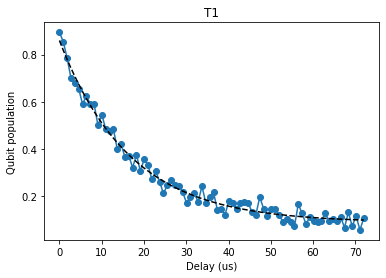

In [72]:
T1(0,0.9,80,200,plot=True, save=False, trial="with_threshold")

# 

# 

# 

# 

# 

In [58]:
class RamseyProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_wait = 3
        self.r_phase2 = 4
        self.r_phase=self.sreg(cfg["qubit_ch"], "phase")
        self.regwi(self.q_rp, self.r_wait, cfg["start"])
        self.regwi(self.q_rp, self.r_phase2, 0)
        
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        
        for ch in [0,1]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["qubit_ch"])
               
        self.add_DRAG(ch=cfg["qubit_ch"], name="drive", length=cfg["pulse_length"], sigma=cfg["pulse_length"],
                      delta=cfg["delta"], alpha=cfg["alpha"])
        self.add_gauss(ch=cfg["qubit_ch"], name="measure", sigma=cfg["res_sigma"], length=cfg["res_length"])
        
        self.sync_all(self.us2cycles(0.2))
    
    def body(self):
        cfg=self.cfg
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["qubit_ch"], ro_ch=0) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])

        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=0, gain=int(cfg["pi_gain"]/2), 
                                 waveform="drive")
        
        self.regwi(self.q_rp, self.r_phase, 0)
        
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.mathi(self.q_rp, self.r_phase, self.r_phase2,"+",0)
        self.sync_all()
        self.sync(self.q_rp,self.r_wait)

        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05))

        
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="flat_top", waveform="measure", freq=f_res, length=cfg["res_length"], 
                                 gain=cfg["res_gain"], phase=cfg["res_phase"])
        
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=cfg["adc_trig_offset"])
        
        self.pulse(ch=cfg["qubit_ch"], t=0)
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

        
    def update(self):
        self.mathi(self.q_rp, self.r_wait, self.r_wait, '+', self.cfg["step"]) # update the time between two π/2 pulses
        self.mathi(self.q_rp, self.r_phase2, self.r_phase2, '+', self.cfg["phase_step"]) # advance the phase of the LO for the second π/2 pulse

In [61]:
def T2(delta, start, step, p_step, expts, reps, plot=None, save=None, trial=None):
    expt_cfg={"start":soccfg.us2cycles(start), "step":soccfg.us2cycles(step), "phase_step": soccfg.deg2reg(p_step, gen_ch=2),
              "expts":expts, "reps": reps, "rounds": 1
           }
    config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs
    config["f_ge"]-=delta
    if config["threshold"] is not None:
        corr=config["readout_length"]
    else:
        corr=1
    t2p=RamseyProgram(soccfg, config)
    x_pts, avgi, avgq= t2p.acquire(soc,threshold=config["threshold"], angle=config["angle"], load_pulses=True,progress=True, debug=False)

    results=np.sqrt(avgi[0][0]**2+avgq[0][0]**2)*corr
    
    p_guess=[np.max(results)*0.8, 4*np.pi*delta, 15, np.mean(results)]
    p_optt2, p_covt2 = curve_fit(t2fit, soccfg.cycles2us(x_pts), results, p0 = p_guess)
    p_errt2 = np.sqrt(np.diag(p_covt2))
    
    fitfunc=t2fit(soccfg.cycles2us(x_pts),p_optt2[0],p_optt2[1],p_optt2[2],p_optt2[3])
    fitvalues=p_optt2
    fitvalueserr=p_errt2
    
    plotsave1d(plot=plot, save=save, title="T2", trial=trial, xvar=soccfg.cycles2us(x_pts),
               xvarname="Delay (us)", ydata=results, ydataname="Qubit population", fitfunc=fitfunc, Shape="square pulse",
               Delta=delta, Fitvalues=fitvalues, Fitvalueserr=fitvalueserr)
    Delta=p_optt2[1]/(4*np.pi)
    
    return {'T2':p_optt2[2], 'Delta':Delta}#, 'results':results}

  0%|          | 0/30000 [00:00<?, ?it/s]

{'T2': 30.005459559177904, 'Delta': 0.170243051881729}

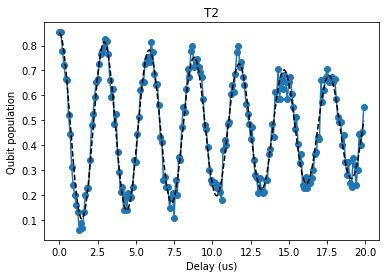

In [62]:
T2(0.1, 0, 0.1, 0.72, 200, 150, plot=True)

# 

# 

# 

# 

# 

# 

# 

## Randomized benchmarking with Clifford gates

In [31]:
class summon_gate(AveragerProgram):
    def initialize(self):
        self.declare_gen(ch=self.cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["f_res"], gen_ch=self.cfg["qubit_ch"])
        
        global phase
        phase=self.deg2reg(0, gen_ch=self.cfg["qubit_ch"])
        
        global f_res
        global f_ge

        f_res=self.freq2reg(self.cfg["f_res"]-self.cfg["detuning"], gen_ch=self.cfg["qubit_ch"], ro_ch=0)
        f_ge=self.freq2reg(self.cfg["f_ge"]-self.cfg["detuning"], gen_ch=self.cfg["qubit_ch"])
            
        self.add_DRAG(ch=self.cfg["qubit_ch"], name="drive", length=self.cfg["pulse_length"], 
                      sigma=self.cfg["pulse_length"], delta=self.cfg["delta"], alpha=self.cfg["alpha"])
        self.add_gauss(ch=self.cfg["qubit_ch"], name="measure", sigma=self.cfg["res_sigma"],
                       length=self.cfg["res_length"])
        
        self.synci(200)

    def body(self):
        for i in self.cfg["gate_sequence"]:    
            if i == 0: #Identity
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, gain=0, style="arb",waveform="drive", phase=phase)
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            elif i == 1: #X
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, gain=self.cfg["pi_gain"], style="arb", 
                                         waveform="drive", phase=phase)
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            elif i == 2: #Y
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, phase=phase+90, gain=self.cfg["pi_gain"], 
                                         style="arb", waveform="drive")
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            elif i == 3: #X2
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, gain=int(self.cfg["pi_gain"]/2), 
                                         style="arb", waveform="drive", phase=phase)
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            elif i == 4: #Y2
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, phase=phase+90,
                                     gain=int(self.cfg["pi_gain"]/2), style="arb", waveform="drive")
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            elif i == 5: #-X2
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, phase=phase+180, gain=int(self.cfg["pi_gain"]/2),
                                         style="arb", waveform="drive")
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            elif i == 6: #-Y2
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, phase=phase+270,
                                     gain=int(self.cfg["pi_gain"]/2), style="arb", waveform="drive")
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            elif i == 7: #-X
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, gain=self.cfg["pi_gain"], phase=phase+180, 
                                         style="arb", waveform="drive")
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            elif i == 8: #-Y
                self.set_pulse_registers(ch=self.cfg["qubit_ch"], freq=f_ge, phase=phase+270, 
                                         gain=self.cfg["pi_gain"], style="arb", waveform="drive")
                self.pulse(ch=self.cfg["qubit_ch"])
                self.sync_all(self.cfg["sync_time"])
            else:
                raise ValueError("'cfg[gate_sequence] value does not correspond to basic a generator [0,8]'")
        #Readout
        self.sync_all(self.cfg["drive_ro_delay"])

        self.set_pulse_registers(ch=self.cfg["qubit_ch"], style="flat_top", waveform="measure", freq=f_res,
                                 length=self.cfg["res_length"], gain=self.cfg["res_gain"], phase=phase)

        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])

        self.pulse(ch=self.cfg["qubit_ch"])
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

In [48]:
def gen_Clifford_seq(m, gate=None):
    gates = [0,1,2,3,4,5,6,7,8]
    gates_inv = [0,7,8,5,6,3,4,1,2]
    cliffords = [[0],[1],[2],[2,1],[3,4],[3,6],[5,4],[5,6],[4,3],[4,5],[6,3],[6,5],
                 [3],[5],[4],[6],[5,4,3],[5,6,3],[1,4],[1,6],[2,3],[2,5],[3,4,3],[5,4,5]]

    gate_seq = []
    #a = np.random.randint(0,23,int(m))
    a = np.ones(int(m)).astype(int)
    for i in a:
        gate_seq.extend(cliffords[i])
        if gate is not None:
            gate_seq.append(gate)
    first_run=np.copy(gate_seq)
    
    for j in np.flip(first_run):
        gate_seq.append(gates_inv[j])
            
    return gate_seq

In [68]:
def SingleGateRandFidelity(m_arr, gm_arr, gate):
    
    probs=[]   
    for m in tqdm(m_arr):
        prob=[]
        for ii in range(10):
            gates = gen_Clifford_seq(m)
            print(gates)
            cliff_cfg={"reps":100, "gate_sequence": gates, "wait_sequence":qubit_cfg["pulse_length"], 
                       "detuning":0, "sync_time":soccfg.us2cycles(0.01, gen_ch=2)} #10 ns time b/w gates is good for 16ns T1
            config={**hw_cfg,**readout_cfg,**qubit_cfg, **cliff_cfg}
            sg=summon_gate(soccfg, config)
            avgi, avgq=sg.acquire(soc, threshold=config["threshold"], angle=config["angle"], load_pulses=True, progress=False,debug=False)
            prob.append(avgi[0]*config["readout_length"])
        probs.append(np.mean(prob))
        
    
    gprobs=[]
    for gm in tqdm(gm_arr):
        for ii in range(10):
            gprob=[]
            ggates = gen_Clifford_seq(gm, gate)
            config["gate_sequence"]=ggates
            sg=summon_gate(soccfg, config)
            avgi, avgq=sg.acquire(soc, threshold=config["threshold"], angle=config["angle"], load_pulses=True, progress=False,debug=False)
            gprob.append(avgi[0]*config["readout_length"])
        gprobs.append(np.mean(gprob))

    figure, axis = plt.subplots(1, 2, figsize=[16,8])
    axis[0].plot(m_arr, probs,'ko')
    axis[1].plot(gm_arr, gprobs,'ko')
    

    p_guess = [-1,1,1]
    p_opt, p_cov = curve_fit(exp_decay, m_arr, probs, p0 = p_guess)
    p_err = np.sqrt(p_cov)

    gp_opt, gp_cov = curve_fit(exp_decay, gm_arr, gprobs, p0 = p_guess)
    gp_err = np.sqrt(gp_cov)


    p = p_opt[0]
    p_inter = gp_opt[0]
    rand_fidelity = 1 - ((1-p)/(2*1.875))
    inter_fidelity = (1+p_inter/p)/2



    xfit = np.linspace(min(m_arr),max(m_arr),1000)
    yfit = exp_decay(xfit, p_opt[0],p_opt[1],p_opt[2])
    axis[0].plot(xfit, yfit,'-')
    axis[0].set_xlabel("Number of Cliffords (m)")
    axis[0].set_ylabel("Qubit population")
    axis[0].set_title("Cliffords")
    
    gxfit = np.linspace(min(gm_arr),max(gm_arr),1000)
    gyfit = exp_decay(gxfit, gp_opt[0],gp_opt[1],gp_opt[2])
    axis[1].plot(gxfit, gyfit,'-')
    axis[1].set_xlabel("Number of Cliffords (m)")
    axis[1].set_ylabel("Qubit population")
    axis[1].set_title("Interleaved Gate + Cliffords")
    #plt.savefig('First_benchmarking.pdf')
    print("Randomized clifford benchmarking fidelity is: " + str(rand_fidelity))
    print("Interleaved clifford benchmarking fidelity for the " + str(gatelist[int(gate)]) + " gate is: " + str(inter_fidelity))
    return rand_fidelity, inter_fidelity

  0%|          | 0/51 [00:00<?, ?it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1, 7]
[1, 7]
[1, 7]
[1, 7]
[1, 7]
[1, 7]
[1, 7]
[1, 7]
[1, 7]
[1, 7]
[1, 1, 7, 7]
[1, 1, 7, 7]
[1, 1, 7, 7]
[1, 1, 7, 7]
[1, 1, 7, 7]
[1, 1, 7, 7]
[1, 1, 7, 7]
[1, 1, 7, 7]
[1, 1, 7, 7]
[1, 1, 7, 7]
[1, 1, 1, 7, 7, 7]
[1, 1, 1, 7, 7, 7]
[1, 1, 1, 7, 7, 7]
[1, 1, 1, 7, 7, 7]
[1, 1, 1, 7, 7, 7]
[1, 1, 1, 7, 7, 7]
[1, 1, 1, 7, 7, 7]
[1, 1, 1, 7, 7, 7]
[1, 1, 1, 7, 7, 7]
[1, 1, 1, 7, 7, 7]
[1, 1, 1, 1, 7, 7, 7, 7]
[1, 1, 1, 1, 7, 7, 7, 7]
[1, 1, 1, 1, 7, 7, 7, 7]
[1, 1, 1, 1, 7, 7, 7, 7]
[1, 1, 1, 1, 7, 7, 7, 7]
[1, 1, 1, 1, 7, 7, 7, 7]
[1, 1, 1, 1, 7, 7, 7, 7]
[1, 1, 1, 1, 7, 7, 7, 7]
[1, 1, 1, 1, 7, 7, 7, 7]
[1, 1, 1, 1, 7, 7, 7, 7]
[1, 1, 1, 1, 1, 7, 7, 7, 7, 7]
[1, 1, 1, 1, 1, 7, 7, 7, 7, 7]
[1, 1, 1, 1, 1, 7, 7, 7, 7, 7]
[1, 1, 1, 1, 1, 7, 7, 7, 7, 7]
[1, 1, 1, 1, 1, 7, 7, 7, 7, 7]
[1, 1, 1, 1, 1, 7, 7, 7, 7, 7]
[1, 1, 1, 1, 1, 7, 7, 7, 7, 7]
[1, 1, 1, 1, 1, 7, 7, 7, 7, 7]
[1, 1, 1, 1, 1, 7, 7, 7, 7, 7]
[1, 1, 1, 1, 1, 7, 7, 7, 7, 7]
[1, 1, 1, 1, 1, 1, 7

  0%|          | 0/51 [00:00<?, ?it/s]

Randomized clifford benchmarking fidelity is: 0.5612266540559903
Interleaved clifford benchmarking fidelity for the X gate is: 0.9540006092783704


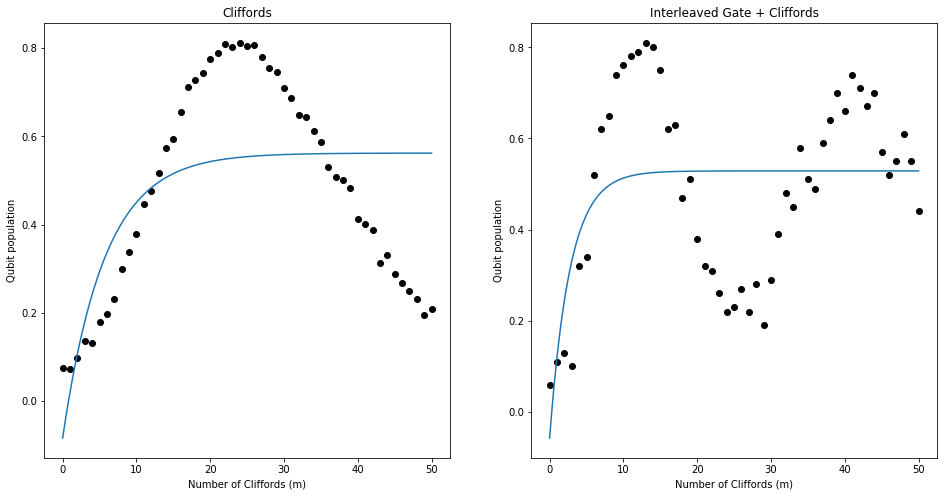

In [73]:
m_arr = np.linspace(0,50,51)
gm_arr = np.linspace(0,50,51)
gate = 1
#gatelist = ["I","X","Y","X2","Y2","-X2","-Y2","-X","-Y"]
    
r_fid, i_fid = SingleGateRandFidelity(m_arr, gm_arr, gate)

In [66]:
plt.savefig('First_benchmarking.pdf')

<Figure size 432x288 with 0 Axes>

# 

# 

# 

# 

# 

# 

# To-do list

### Do DRAG correction optimization-> Joao ok
### Hahn echo/CPMG -> Jeffrey
### Make Amplitude Rabi work -> Joao

## DC stuff -> Jeffrey

## Feed-forward stuff -> Joao

## Two-qubit stuff -> Both